# ViT 

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision.transforms as transforms
from torchvision import datasets

import os

import numpy as np
import matplotlib.pyplot as plt
import logging 

logging.basicConfig(level=logging.DEBUG, filename='logs/vit_tinyImageNet_fromscratch.log', filemode='w', format='%(message)s')

def create_val_img_folder(data_dir, dataset):
    '''
    This method is responsible for separating validation images into separate sub folders
    '''
    dataset_dir = os.path.join(data_dir, dataset)
    val_dir = os.path.join(dataset_dir, 'val')
    img_dir = os.path.join(val_dir, 'images')

    fp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')
    data = fp.readlines()
    val_img_dict = {}
    for line in data:
        words = line.split('\t')
        val_img_dict[words[0]] = words[1]
    fp.close()

    # Create folder if not present and move images into proper folders
    for img, folder in val_img_dict.items():
        newpath = (os.path.join(img_dir, folder))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        if os.path.exists(os.path.join(img_dir, img)):
            os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))


def prepare_imagenet(data_dir, dataset, pretrained=False):
    dataset_dir = os.path.join(data_dir, dataset)
    train_dir = os.path.join(dataset_dir, 'train')
    val_dir = os.path.join(dataset_dir, 'val', 'images')
    test_dir = os.path.join(dataset_dir, 'test', 'images')

    # Pre-calculated mean & std on imagenet:
    # norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # For other datasets, we could just simply use 0.5:
    # norm = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    print('Preparing dataset ...')
    # Normalization
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #\
        # if pretrained else transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    # Normal transformation
    if pretrained:
        train_trans = [transforms.RandomHorizontalFlip(), transforms.RandomResizedCrop(224), 
                        transforms.ToTensor()]
        val_trans = [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), norm]
    else:
        train_trans = [transforms.RandomHorizontalFlip(), transforms.ToTensor()]
        val_trans = [transforms.ToTensor(), norm]
    test_trans = [transforms.ToTensor(), norm]


    train_data = datasets.ImageFolder(train_dir, 
                                    transform=transforms.Compose(train_trans + [norm]))
    
    val_data = datasets.ImageFolder(val_dir, 
                                    transform=transforms.Compose(val_trans))
    test_data = datasets.ImageFolder(test_dir, 
                                    transform=transforms.Compose(test_trans))
    
    print('Preparing data loaders ...')
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, 
                                                    shuffle=True, num_workers=4)
    
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, 
                                                    shuffle=True, num_workers=4)
    
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False, num_workers=4)
    
    
    return train_data_loader, val_data_loader, test_data_loader, train_data, val_data

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
create_val_img_folder('./data', 'tiny-imagenet-200')
trainloader, valloader, testloader, _, val_data = prepare_imagenet('./data', 'tiny-imagenet-200')
idx_to_class = {i: c for c, i in val_data.class_to_idx.items()}

# Model
print('==> Building model..')

from vit_pytorch import ViT

net = ViT(
    image_size = 64,
    patch_size = 16,
    num_classes = 200,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

# # To load checkpoint
# checkpoint = torch.load('./checkpoint/vit_tinyImageNet.pth')
# # # for all keys in the checkpoint["net"], change the key name to remove the 'module.' prefix
# checkpoint["net"] = {k.replace('module.', ''): v for k, v in checkpoint["net"].items()}
# net.load_state_dict(checkpoint["net"])


# count number of elements in the model
# pytorch_total_params = sum(p.numel() for p in net.parameters())
# print(pytorch_total_params)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

Preparing dataset ...
Preparing data loaders ...
==> Building model..
13120712


In [3]:
# Training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Instead of use progress bar, print it directly
        if batch_idx % 10 == 0:
            logging.debug(f'Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')
        train_losses.append(train_loss/(batch_idx+1))
        train_accuracies.append(100.*correct/total)

        
def test(epoch):
    global best_acc
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:
                logging.debug(f'>>> Validation Loss: {valid_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')
        # Append average loss and accuracy
        test_losses.append(valid_loss/(batch_idx+1))
        test_accuracies.append(100.*correct/total)
            
            
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/vit_tinyImageNet.pth')
        best_acc = acc


def print_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = len(test_losses)
    total_train_points = len(train_losses)
    epoch_indices = np.linspace(0, total_train_points - 1, epochs, dtype=int)

    # Downsampling training losses to match the number of epochs
    # We select points from train_losses at positions matching to test_losses
    train_losses_sampled = [train_losses[i] for i in epoch_indices]

    # Plotting both sets of losses
    plt.figure(figsize=(30, 5))
    plt.plot(train_losses_sampled, label='Train Loss (Sampled)')
    plt.plot(test_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss per Epoch')
    plt.xticks(range(epochs), labels=[f'{i+1}' for i in range(epochs)])  # Set x-ticks to epoch numbers
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the accuracies curves
    epochs = len(test_accuracies)
    total_train_points = len(train_accuracies)
    epoch_indices = np.linspace(0, total_train_points - 1, epochs, dtype=int)
    # print(epoch_indices)
    train_accuracies_sampled = [train_accuracies[i] for i in epoch_indices]
    plt.figure(figsize=(30, 5))
    plt.plot(train_accuracies_sampled, label='Train Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy per Epoch')
    plt.xticks(range(epochs), labels=[f'{i+1}' for i in range(epochs)])  # Set x-ticks to epoch numbers
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0


Saving..

Epoch: 1
Saving..

Epoch: 2
Saving..

Epoch: 3
Saving..

Epoch: 4
Saving..

Epoch: 5
Saving..

Epoch: 6
Saving..

Epoch: 7
Saving..

Epoch: 8
Saving..

Epoch: 9
Saving..

Epoch: 10

Epoch: 11

Epoch: 12
Saving..

Epoch: 13
Saving..

Epoch: 14
Saving..

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20
Saving..

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25

Epoch: 26

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30

Epoch: 31

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35

Epoch: 36

Epoch: 37

Epoch: 38

Epoch: 39

Epoch: 40

Epoch: 41

Epoch: 42

Epoch: 43

Epoch: 44

Epoch: 45

Epoch: 46

Epoch: 47

Epoch: 48

Epoch: 49


In [11]:
correct = 0
total = 0

# Set the model to evaluation mode
net.eval()

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # print(labels)

        # Count the number of correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate test set accuracy
accuracy = 100 * correct / total

print('Meaningless test accuracy because we do not have labels for test set')
print('Test Set Accuracy: {:.2f}%'.format(accuracy))


Meaningless test accuracy because we do not have labels for test set
Test Set Accuracy: 0.68%


{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695', 20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799', 30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429', 40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003', 50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 57: 'n02504458', 58: 'n02509815', 59: 'n

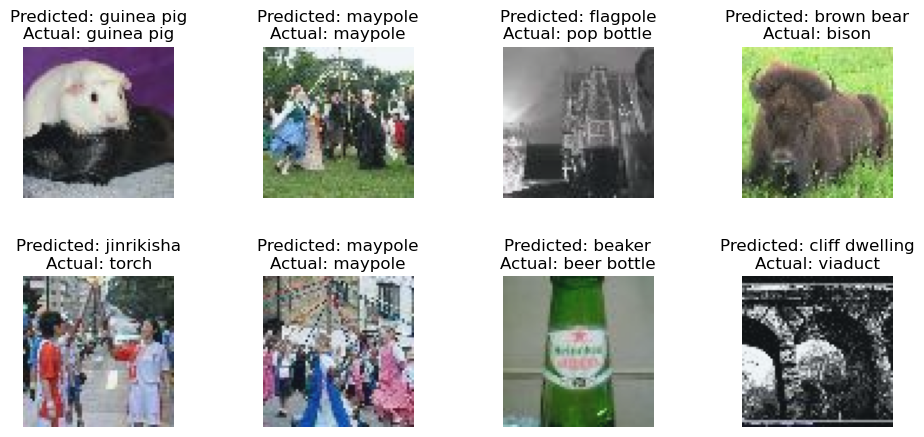

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
net.eval()
print(idx_to_class)

# read from words.txt to get the english name of the class
with open('./data/tiny-imagenet-200/words.txt', 'r') as f:
    words = f.readlines()
    class_to_name = {}
    for line in words:
        line = line.split('\t')
        class_to_name[line[0]] = line[1].split(',')[0].strip()

# print(class_to_name)

# Iterate over the testloader
for images, labels in valloader:
    # Move images and labels to the device
    images = images[:8].to(device)
    labels = labels[:8].to(device)
    
    # Forward pass
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    
    # Convert tensors to numpy arrays
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # print(images.shape)
    # print(labels.shape)
    # print(predicted.shape)
    
    # Visualize the images and classification results
    fig, axes = plt.subplots(2, len(images)//2, figsize=(10, 5))
    fig.tight_layout(pad=3.0)

    for i, ax in enumerate(axes.flat):
        # Convert the image from tensor to numpy array
        image = np.transpose(images[i], (1, 2, 0))
        
        # Denormalize the image
        image = image * np.array([0.2023, 0.1994, 0.201]) + np.array([0.4914, 0.4822, 0.4465])
        
        # Clip the pixel values to [0, 1]
        image = np.clip(image, 0, 1)
        
        # Plot the image and set the title
        ax.imshow(image)
        predicted_label = idx_to_class[predicted[i]]
        actual_label = idx_to_class[labels[i]]
        

        ax.set_title(f"Predicted: {class_to_name[predicted_label]}\nActual: {class_to_name[actual_label]}")
        
        # Remove the axis ticks
        ax.axis('off')
    
    # Show the plot
    plt.show()
    break



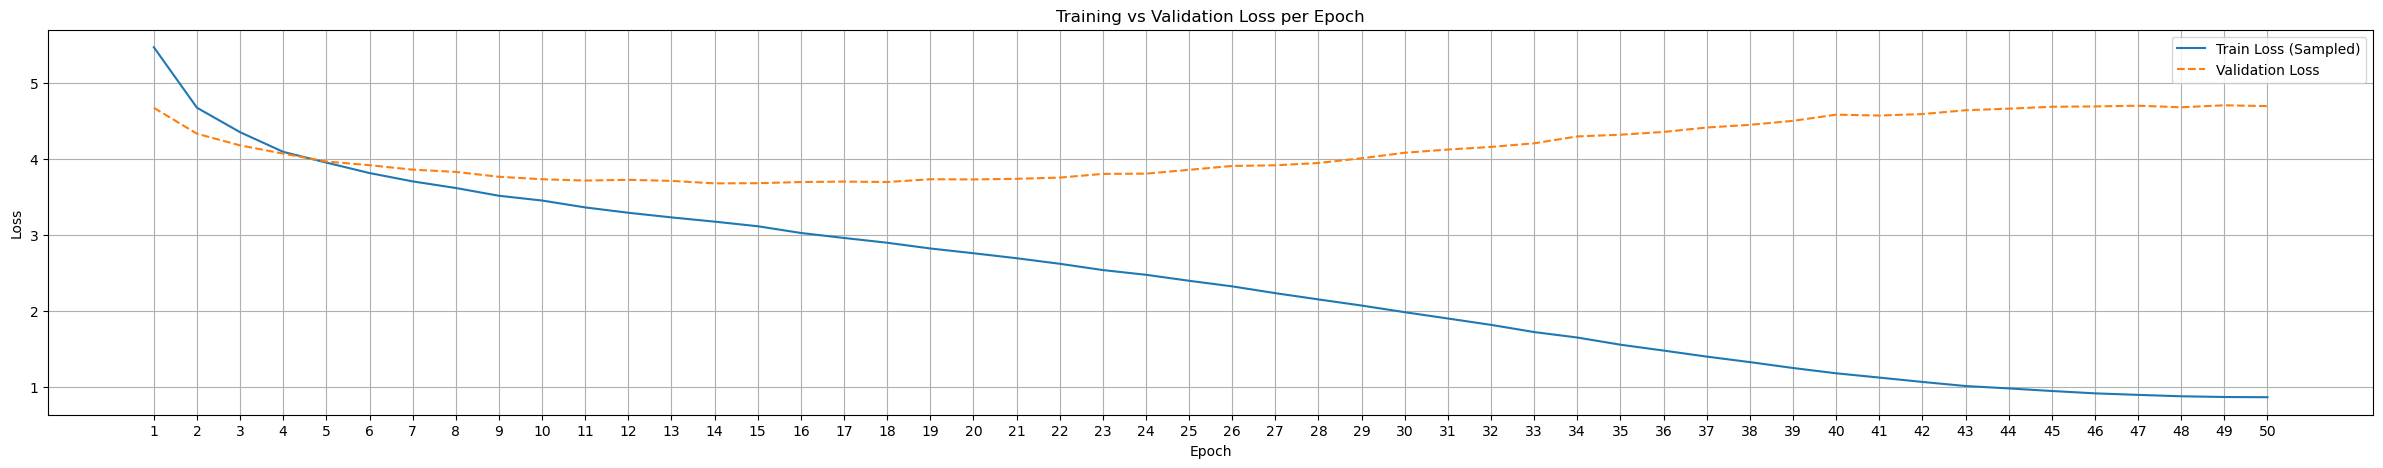

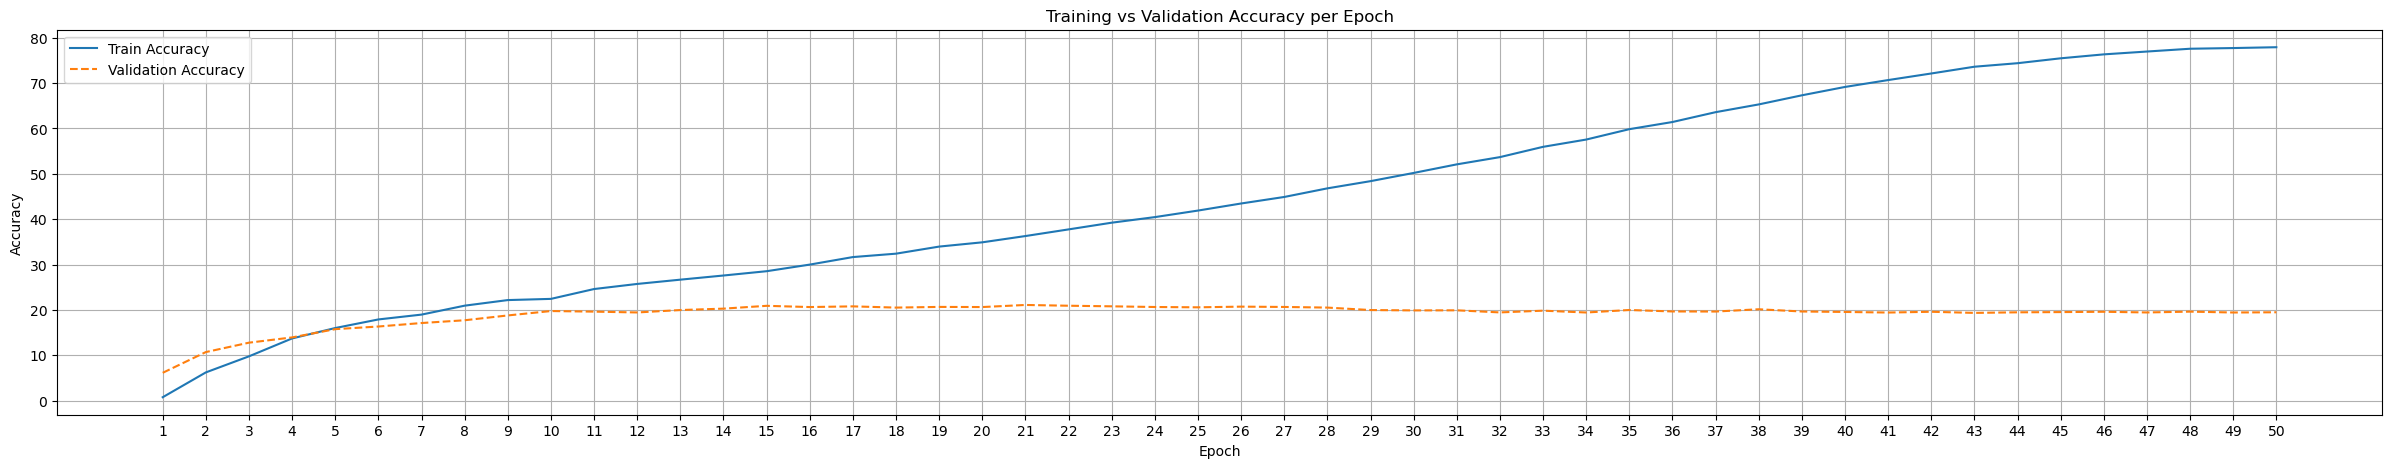

None


In [7]:
# save the losses and accuracies using np.savez to the a file with the name 'resnet18_tinyImageNet_fromscratch.npy'
np.savez(os.path.join('losses_and_accuracies', 'vit_tinyImageNet_fromscratch.npz'), train_losses=train_losses, test_losses=test_losses, train_accuracies=train_accuracies, test_accuracies=test_accuracies)
# to load them:
# data = np.load(os.path.join('losses_and_accuracies', 'resnet18_tinyImageNet_fromscratch.npz'))
# train_losses = data['train_losses']
# test_losses = data['test_losses']
# train_accuracies = data['train_accuracies']

print(print_curves(train_losses, test_losses, train_accuracies, test_accuracies))

# Visualize Attention Map

# All layers
    

torch.Size([3, 64, 64])
torch.Size([1, 200]) torch.Size([1, 8, 8, 17, 17])
att_mat has shape torch.Size([8, 8, 17, 17])


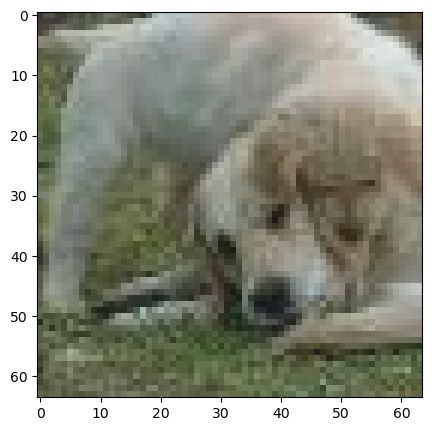

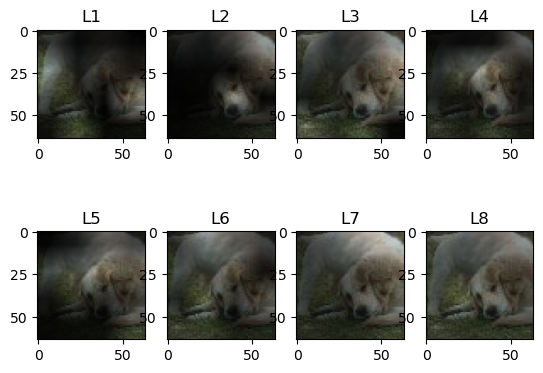

In [29]:
import cv2
from vit_pytorch import ViT

net = ViT(
    image_size = 64,
    patch_size = 16,
    num_classes = 200,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)


from vit_pytorch.recorder import Recorder
net = Recorder(net)
# load the checkpoint of the model from checkpoint/vit_tinyImageNet.pth
checkpoint = torch.load('./checkpoint/vit_tinyImageNet.pth')
# # for all keys in the checkpoint["net"], change the key name to remove the 'module.' prefix
checkpoint["net"] = {k.replace('module.', 'vit.'): v for k, v in checkpoint["net"].items()}

net.load_state_dict(checkpoint["net"])
net = net.to(device)



for i, (data, target) in enumerate(testloader):
    # Choose the dog image
    image_ori = data[4]
    image = image_ori.clone()
    print(image.shape)
    image = image.to(device)
    logits, attentions = net(image.unsqueeze(0))
    
    # att_mat = net.get_attn_weights()
    att_mat = attentions[0].cpu()
    print(f"att_mat has shape {att_mat.shape}")  # [num_layer, num_heads, 17, 17]

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)    # [num_layer, 17, 17]

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    # aug_att_mat has shape [num_layer, 17, 17]

    image_np = image_ori.permute(1, 2, 0).numpy()
    # image = np.transpose(images[i], (1, 2, 0))
    
    # Denormalize the image
    image_np = image_np * np.array([0.2023, 0.1994, 0.201]) + np.array([0.4914, 0.4822, 0.4465])
    
    # Clip the pixel values to [0, 1]
    image_np = np.clip(image_np, 0, 1)
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np)
    plt.show()
    fig, axs = plt.subplots(2,4)
    
    axs[0,0].imshow(image_np)

    for l in range(aug_att_mat.shape[0]):
        # Attention from the output token to the input space.
        v = aug_att_mat[l]
        grid_size = int(np.sqrt(aug_att_mat.size(-1)))
        mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
        mask = np.array(mask / mask.max())
        
        c1_mask = cv2.resize(mask, image.size()[1:])[..., np.newaxis]   # (32,32,1)
        
        mask = np.concatenate((c1_mask, c1_mask, c1_mask), axis=2)      # (32,32,3)

        result = (mask) * image_np
        idx_0 = int((l)/4)
        idx_1 = (l)%4

        axs[idx_0,idx_1].set_title(f'L{l+1}')
        _ = axs[idx_0,idx_1].imshow(result)
        
    plt.show()
    break